# Decision Trees, Visualizing Decision Boundaries, and Evaluation

## Introduction

A decision tree is a non-parametric, supervised learning algorithm that is applicable to both classification and regression tasks, often referred to as a Regression tree. It works by repeatedly splitting the data based on specific parameters. Starting with the **root node**, the data is divided into increasingly homogeneous subsets, forming a tree-like structure. This structure comprises two main elements: **decision nodes** and **leaves**. 

<img src="Image/decision-tree_.png" alt="Drawing" style="width: 500px;"/>

#### Entropy

Entropy is a measure used to quantify the impurity or uncertainty within a dataset. It indicates the level of randomness in the data, influencing how a decision tree makes splits and defines its boundaries. The formula for entropy is

$$Entropy = \sum_{i=1}^c -P_i log_2 (P_i)$$
where $c$ is the total number of classes and $P_i$ is the probability of class $i$ in the node.

From the formula, we can know that the range of entropy is $[0, 1]$. The value of entropy should be as small as possible. 

#### Gini Index

Gini index is used to determine the impurity or purity when building a decision tree in the classification and regression tree (CART) algorithm. The formula of Gini index is

$$Gini= 1 - \sum_{i=1}^c P_i^2$$
where c is the total number of classes and $P_i$ is the probability of class $i$ in the node.

Lower Gini index is better.

#### Information Gain (IG)

Information gain is used to decide which feature to split at each step when building the decision tree. It measures the changes in entropy and is calculated for each split. A decision tree algorithm would maximize the value of information gain, and thus, the split with the highest value of information gain will be selected. If a node $V$ is split into $V_l$ and $V_r$, the formula of information gain is

$$IG = Entropy(V)-w_l \times Entropy(V_l)+w_r \times Entropy(V_r)$$
where $w$ is the weight, that $w_l=\frac {|V_l|}{V}$ and $w_r=\frac {|V_r|}{V}$.


---

## Implement

In the following notebook, I will implement the Decision Tree algorithm for species classification using the [Penguin dataset](https://www.kaggle.com/parulpandey/penguin-dataset-the-new-iris). After classification, I will assess the performance of the algorithm using the confusion matrix. 

### About the dataset

The dataset consists of 344 rows and 7 columns. There are three different species of penguins: Chinstrap, Adélie, and Gentoo penguins. The columns are:

* species: penguin species (Chinstrap, Adélie, or Gentoo)
* island: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
* bill: bill length (mm)
* bill_depth_mm: bill depth (mm)
* flipper_length_mm: flipper length (mm)
* body_mass_g: body mass (g)
* sex: penguin sex

### Objective

Using the bill length and depth, classify penguin species with a decision tree algorithm, display the decision boundaries, and assess the algorithm's performance using a confusion matrix.

### Tools

The following libraries are used in this notebook: 

* [matplotlib](http://metplotlib.org)
* [numpy](https://numpy.org/doc/stable/index.html)
* [pandas](http://pandas.pydata.org)
* [seaborn](https://seaborn.pydata.org/)
* [tree](https://scikit-learn.org/stable/modules/classes.html?highlight=tree#module-sklearn.tree) in [sklearn](https://scikit-learn.org/stable/index.html)
* [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreeclassifier#sklearn.tree.DecisionTreeClassifier) in [sklearn.tree](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree)
* [export_text](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_text.html?highlight=export_text#sklearn.tree.export_text) in [sklearn.tree](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree)
* [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split) in [sklearn.model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* [metrics](https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics) in [sklearn](https://scikit-learn.org/stable/index.html)

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

---

### Data Import and Data Wrangling

Load the dataset and create a scatter plot to gain a general understanding of how the data is distributed.

In [3]:
# Import Penguins dataset
penguins = pd.read_csv("Data/penguins.csv")

# Remove the rows with Na values from the dataset
penguins = penguins.dropna()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

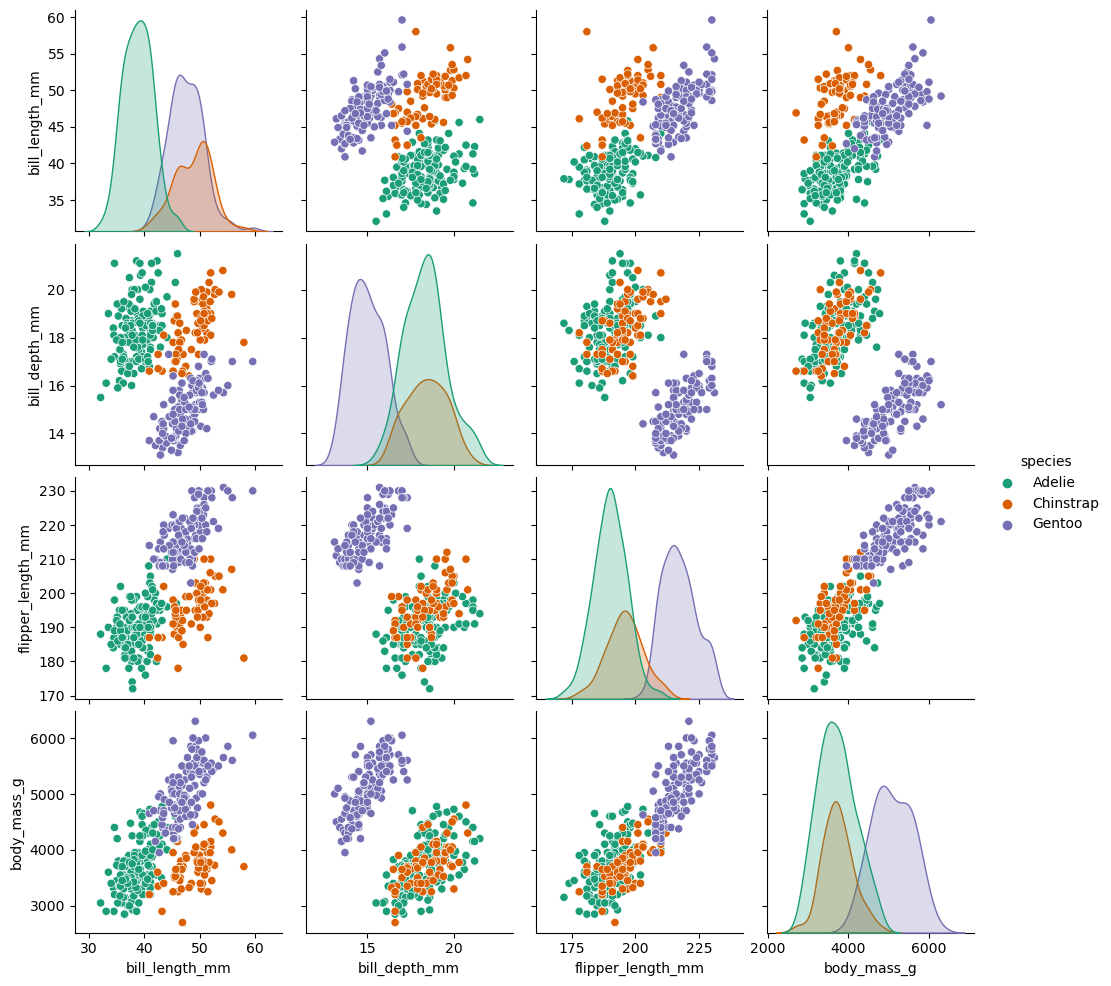

In [4]:
sns.pairplot(penguins, hue='species',palette='Dark2')

Text(0.5, 1.0, 'Penguins Data')

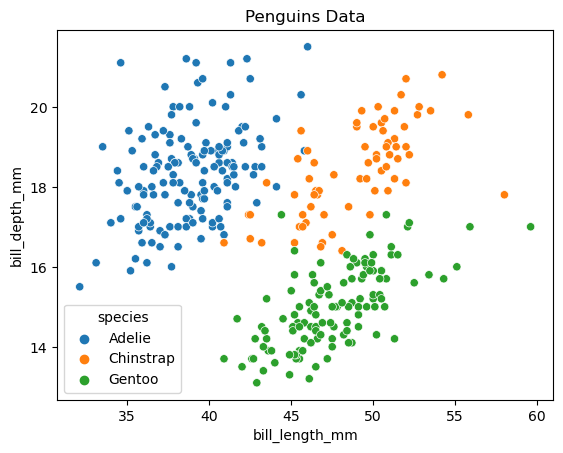

In [5]:
sns.scatterplot(data = penguins, x = "bill_length_mm", y = "bill_depth_mm", hue = 'species').set_title("Penguins Data")

From the scatter plot above, "bill_length_mm" and "bill_depth_mm" separate the three penguin species well. Thus, I will use these two features as predictors.

In [6]:
# Extract desired features from Penguins Dataset, and covert features to numpy array
X = penguins[['bill_length_mm', 'bill_depth_mm']].to_numpy()

# Extract labels, and convert labels to numpy array
y = penguins['species'].to_numpy()

# Change labels to numeric labels
for i, label in enumerate(y):
    if label == "Adelie":
        y[i] = 0.0
    elif label == "Chinstrap":
        y[i] = 1.0
    else:
        y[i] = 2.0

### Train and Test Data Split

In [7]:
# Use the train_test_split function in sklearn package
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.4,
                                                    random_state = 42)

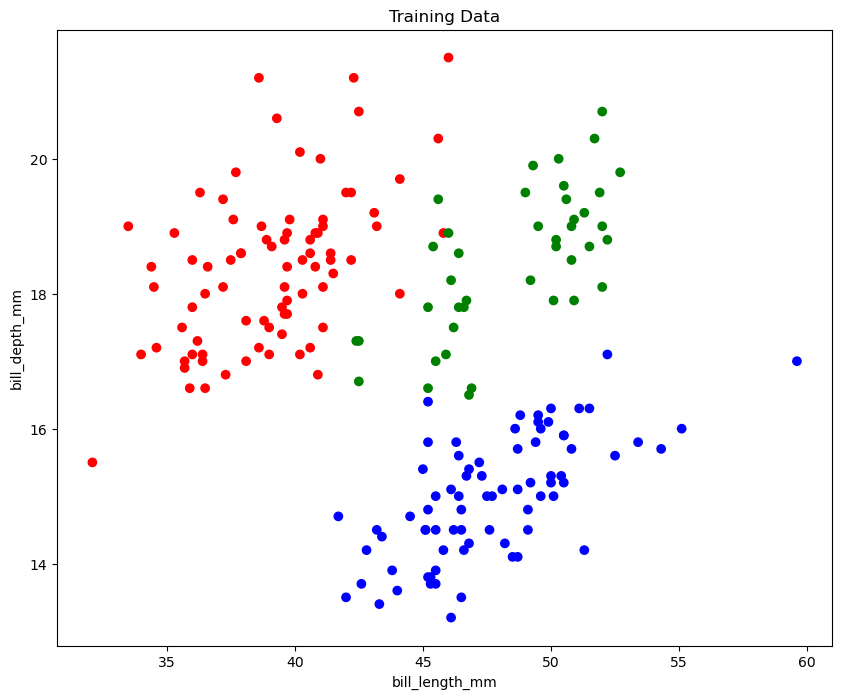

In [8]:
# Scatter plot for the training data
c_train = ["red" if label == 0 else ("green" if label == 1 else "blue") for label in y_train]
c_test = ["red" if label == 0 else ("green" if label == 1 else "blue") for label in y_test]

plt.figure(figsize = (10, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], c = c_train)
plt.xlabel("bill_length_mm")
plt.ylabel("bill_depth_mm")
plt.title("Training Data")
plt.show()

In [9]:
# Make lists for features and labels
features = ["bill_length_mm", "bill_depth_mm"]
labels = ["Adelie", "Chinstrap", "Gentoo"]

---

### Implement Decision Tree

Use the DecisionTreeClassifier from sklearnDocumentation can be found at [tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).

In [10]:
# Using DecisionTreeClassifier to train the data
decision_tree = DecisionTreeClassifier(max_depth = 2, random_state = 42)
decision_tree.fit(X_train, y_train.tolist())

DecisionTreeClassifier(max_depth=2, random_state=42)

### Visualizing the Decision Tree

To plot the tree, use the [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) tool from [sklearn.tree](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree) to visualize the decision tree.

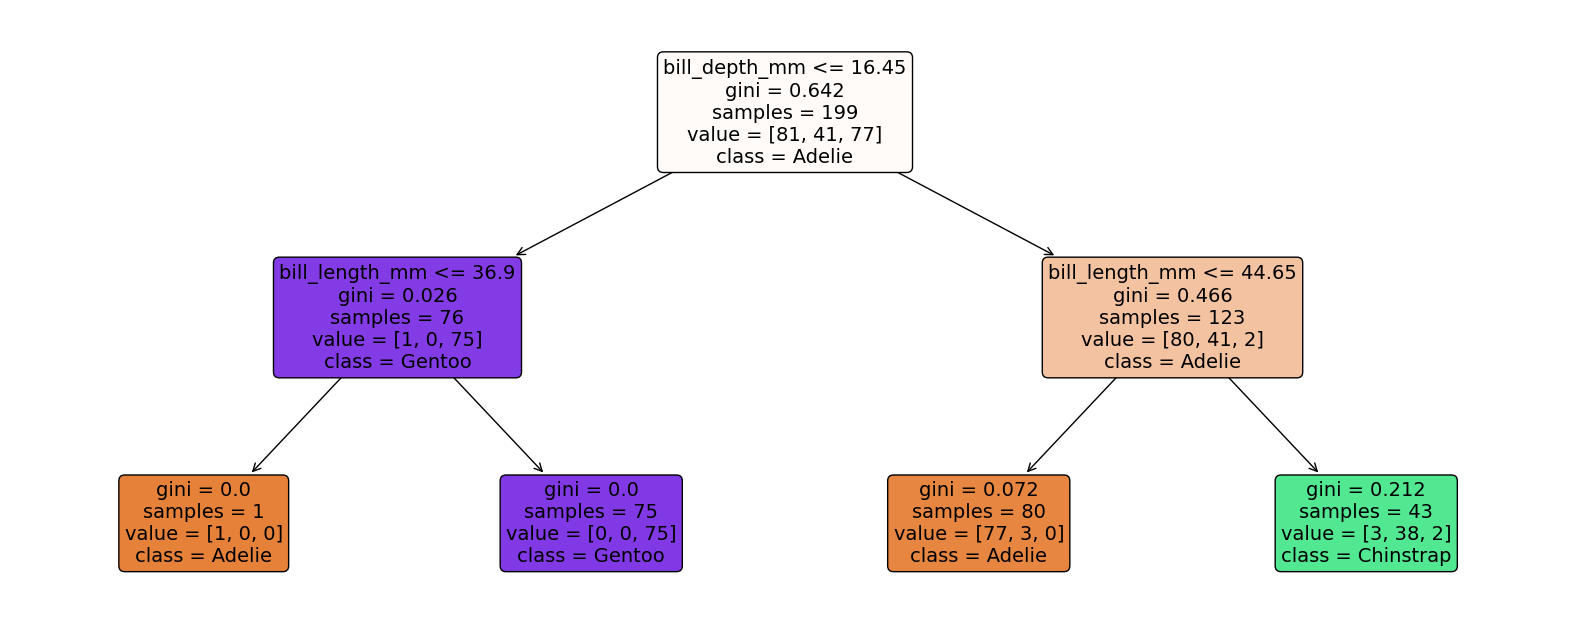

In [11]:
# Plot decision tree using plot_tree
plt.figure(figsize = (20, 8))
a = tree.plot_tree(decision_tree,
                   feature_names = features,
                   class_names = labels,
                   rounded = True,
                   filled = True,
                   fontsize = 14)
plt.show()

The tree plot displays the criteria for node splitting, including the Gini index, sample size, classification, and additional details.

Besides this, use another way to visualize the tree. We use the [export_text](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_text.html#sklearn.tree.export_text) tool from [sklearn.tree](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree). This tool can build a text report showing the rules of a decision tree. Let's see!

In [12]:
## Build a text report for the rules of the tree
tree_rules = export_text(decision_tree,
                         feature_names = features)
print(tree_rules)

|--- bill_depth_mm <= 16.45
|   |--- bill_length_mm <= 36.90
|   |   |--- class: 0.0
|   |--- bill_length_mm >  36.90
|   |   |--- class: 2.0
|--- bill_depth_mm >  16.45
|   |--- bill_length_mm <= 44.65
|   |   |--- class: 0.0
|   |--- bill_length_mm >  44.65
|   |   |--- class: 1.0



---

### Visualizing Decision Boundaries for Training Data

Show the decision boundaries from our trained tree.


Text(0.5, 1.0, 'Decision Boundaries for Training Data')

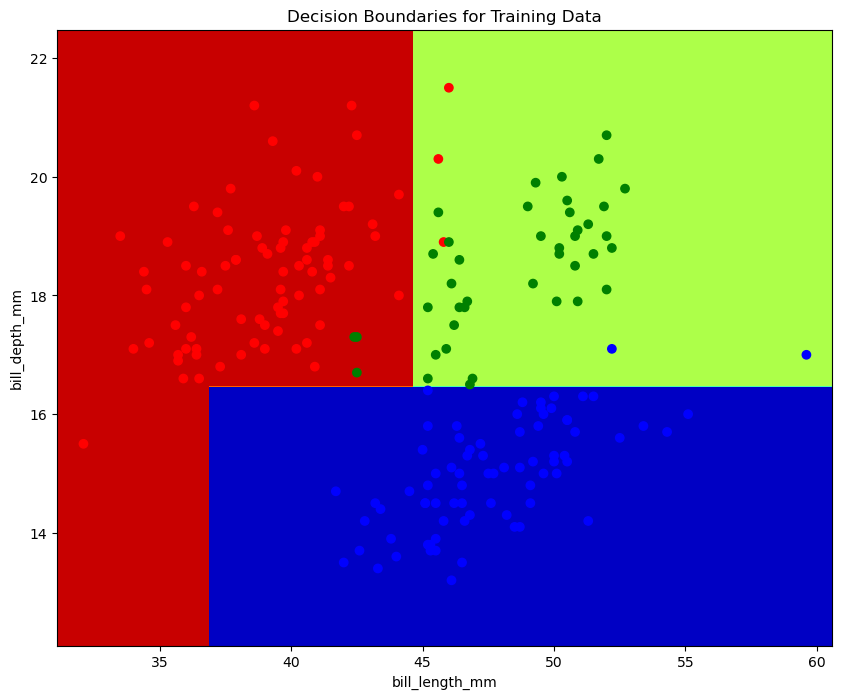

In [13]:
# Set a plot_step
plot_step = 0.02

plt.figure(figsize = (10, 8))

# Plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# plt.tight_layout(h_hap = 0.5, w_pad = 0.5, pad = 2.5)

Z = decision_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap = "jet_r") #blue and red coloring

plt.scatter(X_train[:, 0], X_train[:, 1], c = c_train)
plt.xlabel("bill_length_mm")
plt.ylabel("bill_depth_mm")
plt.title("Decision Boundaries for Training Data")

The decision boundaries plot shows that while most data points are correctly placed, some are misclassified by the model. Therefore, this is used to evaluate the performance of the decision tree algorithm.

---

### Assessing the Performance

Use the confusion matrix to assess the performance of the decision tree algorithm.

---

#### The Confusion Matrix

In many instances we are interested in the following terms:
* true positives -> predicted true and actually true
* false positives -> predicted true and not actually true
* false negatives -> predicted false but actually true
* true negatives -> predicted false and actually false
    
All of these possibilities are contained in the confusion matrix.

We will output the confusion matrix for test data. To achieve this, we need one more tools:

* [metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) tool from sklearn: to generate confusion matrix and calculate the rates and scores.

In [14]:
# predicted values on the testing data
test_pred_decision_tree = decision_tree.predict(X_test)

# Change the data type that can fit the usage of confusion matrix tool
y_test = y_test.astype("float64")

# The confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, test_pred_decision_tree)

# Convert confusion matrix into dataframe
matrix_df = pd.DataFrame(confusion_matrix)

In [15]:
# Output the confusion matrix
print(confusion_matrix)

[[64  0  1]
 [ 3 23  1]
 [ 1  5 36]]


#### Visualize the Confusion Matrix

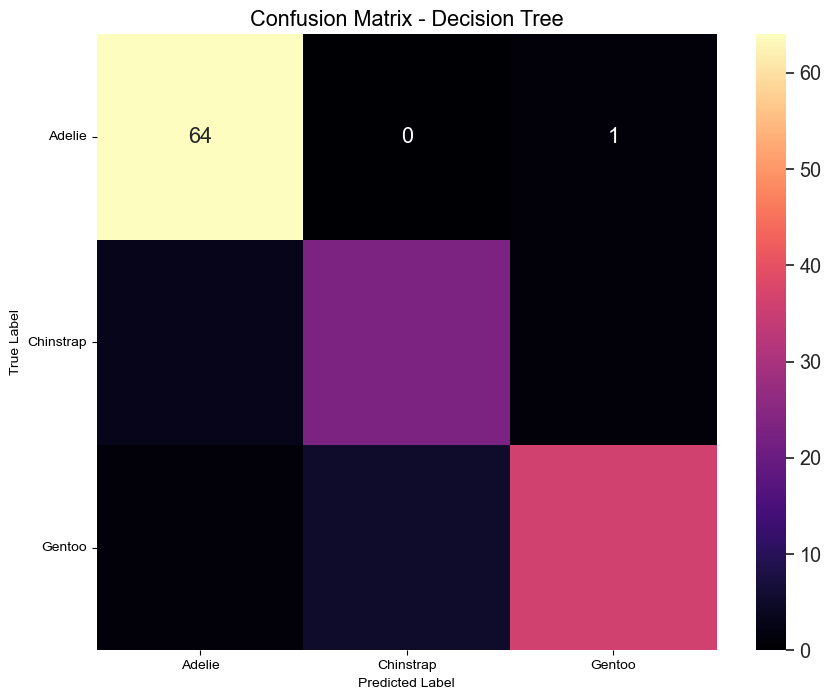

In [16]:
# Plot confusion matrix using seaborn
plt.figure(figsize = (10, 8))
ax = plt.axes()
sns.set(font_scale = 1.3)

sns.heatmap(matrix_df,
            annot = True,
            fmt = "g",
            ax = ax,
            cmap = "magma")

ax.set_title("Confusion Matrix - Decision Tree")
ax.set_xlabel("Predicted Label", fontsize = 10)
ax.set_xticklabels(labels)
ax.set_ylabel("True Label", fontsize = 10)
ax.set_yticklabels(labels, rotation = 0)
plt.show()

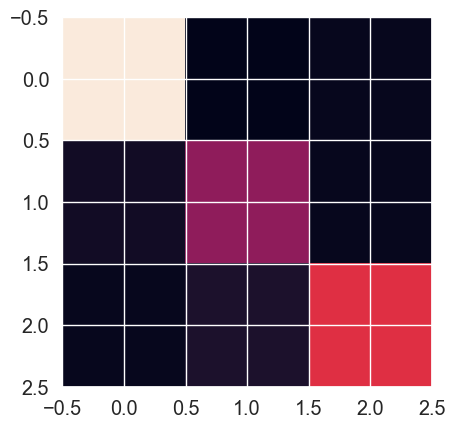

In [17]:
# Using matplotlib to plot the confusion matrix
plt.imshow(confusion_matrix)

---

#### Visualize the Boundaries for Testing Data

Text(0.5, 1.0, 'Decision Boundaries for Testing Data')

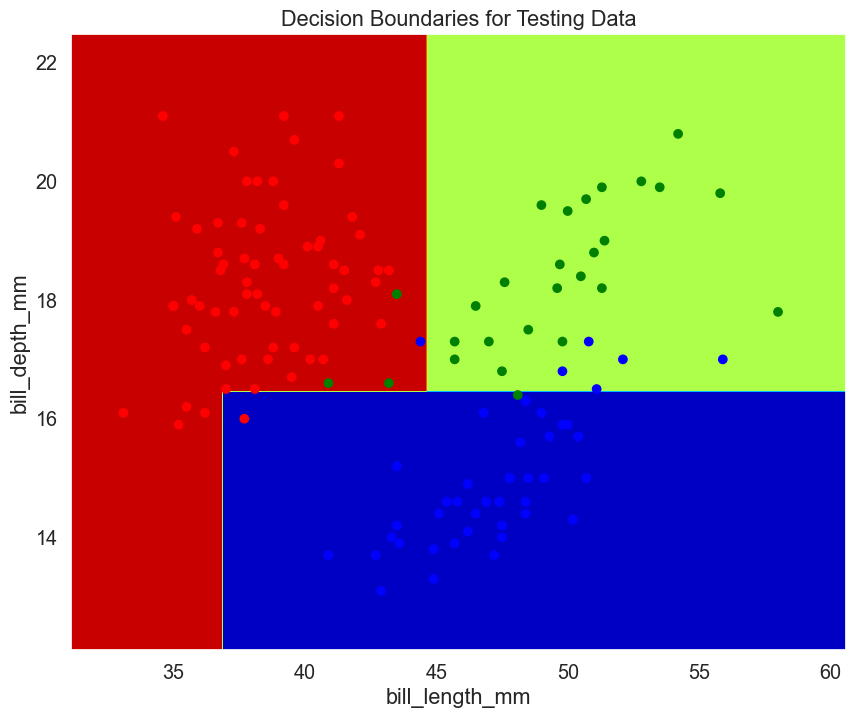

In [18]:
# Set a plot_step
plot_step = 0.02

plt.figure(figsize = (10, 8))

# Plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# plt.tight_layout(h_hap = 0.5, w_pad = 0.5, pad = 2.5)

Z = decision_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap = "jet_r") #blue and red coloring

plt.scatter(X_test[:, 0], X_test[:, 1], c = c_test)
plt.xlabel("bill_length_mm")
plt.ylabel("bill_depth_mm")
plt.title("Decision Boundaries for Testing Data")

While some points are incorrectly predicted, the overall performance is still strong. Let's examine various rates and scores to assess the effectiveness of the decision tree algorithm!

**Accuracy** is the fraction of predictions that the model correctly predicts. 

In [19]:
print(f"accuracy score = {metrics.accuracy_score(y_test, test_pred_decision_tree)}")

accuracy score = 0.917910447761194


The accuracy score is pretty high! Then let's look up the precision.

**Precision** is the proportion of positive identifications that are actually correct. It tells us how many values we predicated to be in a certain class are actually in that class!

$$\text{Precious} = \frac {\text{True Positive}}{\text{True Positive} + \text{False Positive}}$$

In [20]:
print(f"precision score")

precision = metrics.precision_score(y_test,
                                    test_pred_decision_tree,
                                    average = None)

# Convert to pandas dataframe
precision_results = pd.DataFrame(precision, index = labels)

precision_results.rename(columns = {0:"precision"}, inplace = True)
precision_results

precision score


,precision
Adelie,0.941176
Chinstrap,0.821429
Gentoo,0.947368


The precision of the predictions to the Adelie and the Gentoo penguins are pretty good, while the precision of the prediction to the Chinstrap penguins is OK.

Let's also check the recall and the $F_1$ score!

**Recall** is the proportion of actual positives that are identified correctly.

$$\text{Recall} = \frac {\text{True Positive}}{\text{True Positive} + \text{False Negative}}$$

**$F_1$ Score** is another way to show the accuracy, and it is the harmonic mean of the precision and recall.

In [21]:
# Recall and the f1-score
print(metrics.classification_report(y_test, test_pred_decision_tree))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96        65
         1.0       0.82      0.85      0.84        27
         2.0       0.95      0.86      0.90        42

    accuracy                           0.92       134
   macro avg       0.90      0.90      0.90       134
weighted avg       0.92      0.92      0.92       134



Overall, the decision tree algorithm performs very well in classifying penguin species, particularly the Adelie and Gentoo penguins, as evidenced by high accuracy, precision, recall, and $F_1$ scores, all exceeding $0.90$

---

### Increase the Depth of the Algorithm

To have a deeper impression of the decision tree algorithm, I will increase the depth of the algorithm (set max_depth $= 5$) and compare the performance of the previous one (max_depth $= 2$).

In [22]:
# Using DecisionTreeClassifier to train the data, set the max_depth = 5
decision_tree = DecisionTreeClassifier(max_depth = 5, random_state = 42)
decision_tree.fit(X_train, y_train.tolist())

DecisionTreeClassifier(max_depth=5, random_state=42)

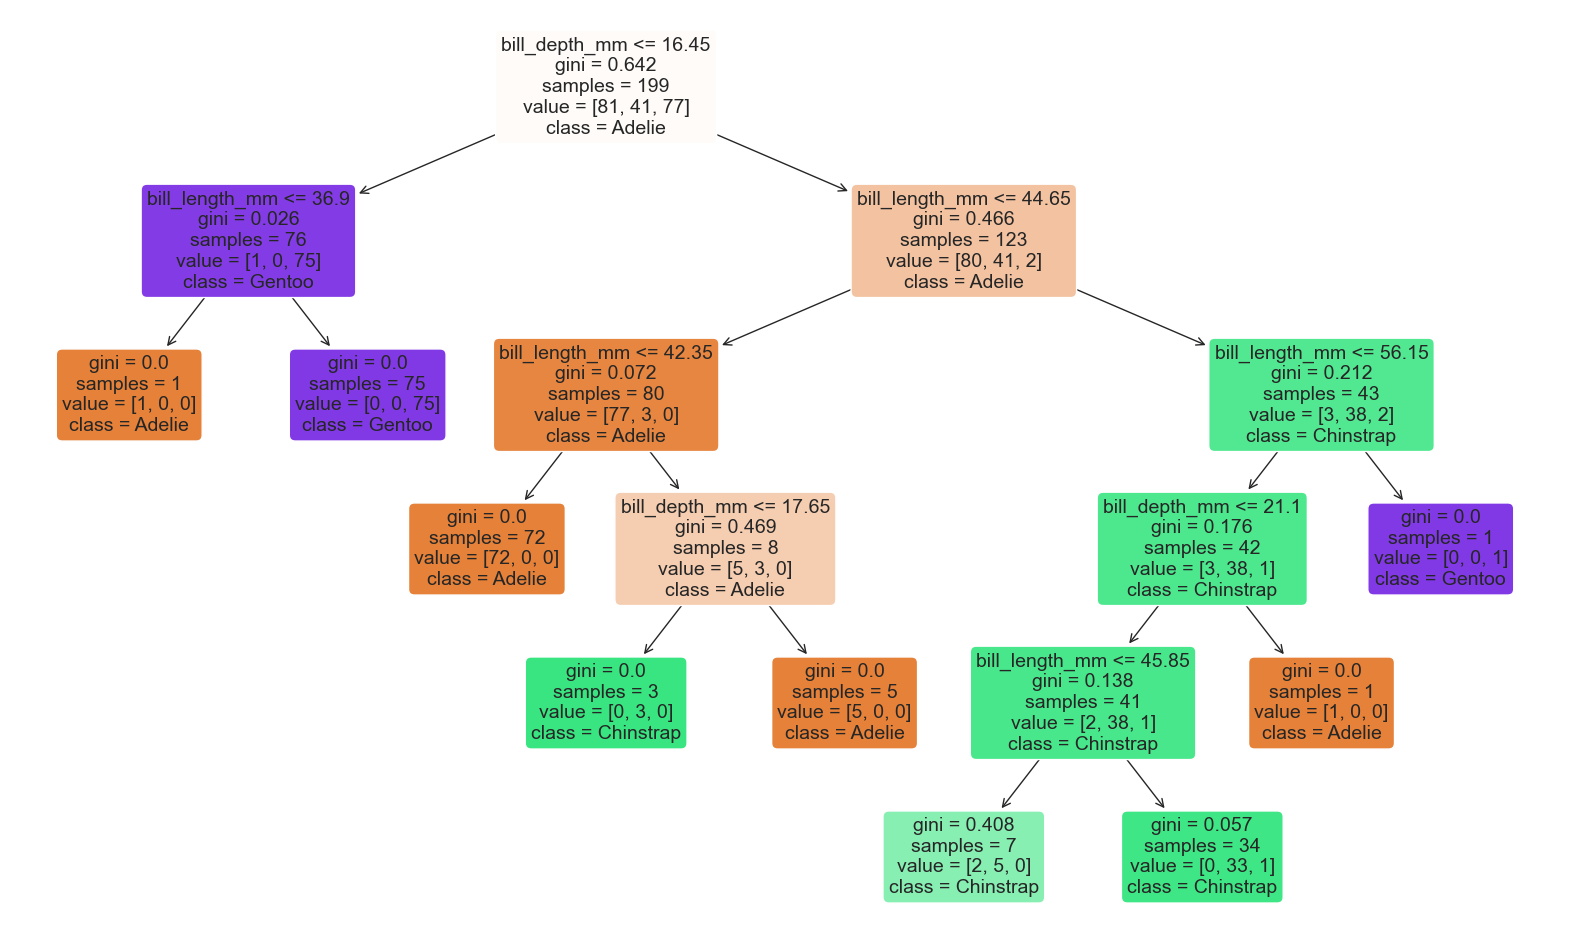

In [23]:
# Plot decision tree using plot_tree
plt.figure(figsize = (20, 12))
a = tree.plot_tree(decision_tree,
                   feature_names = features,
                   class_names = labels,
                   rounded = True,
                   filled = True,
                   fontsize = 14)
plt.show()

In [25]:
## Build a text report for the rules of the tree
tree_rules = export_text(decision_tree,
                         feature_names = features)
print(tree_rules)

|--- bill_depth_mm <= 16.45
|   |--- bill_length_mm <= 36.90
|   |   |--- class: 0.0
|   |--- bill_length_mm >  36.90
|   |   |--- class: 2.0
|--- bill_depth_mm >  16.45
|   |--- bill_length_mm <= 44.65
|   |   |--- bill_length_mm <= 42.35
|   |   |   |--- class: 0.0
|   |   |--- bill_length_mm >  42.35
|   |   |   |--- bill_depth_mm <= 17.65
|   |   |   |   |--- class: 1.0
|   |   |   |--- bill_depth_mm >  17.65
|   |   |   |   |--- class: 0.0
|   |--- bill_length_mm >  44.65
|   |   |--- bill_length_mm <= 56.15
|   |   |   |--- bill_depth_mm <= 21.10
|   |   |   |   |--- bill_length_mm <= 45.85
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- bill_length_mm >  45.85
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- bill_depth_mm >  21.10
|   |   |   |   |--- class: 0.0
|   |   |--- bill_length_mm >  56.15
|   |   |   |--- class: 2.0



Let's see the decision boundaries from the training tree.

Text(0.5, 1.0, 'Decision Boundaries for Training Data')

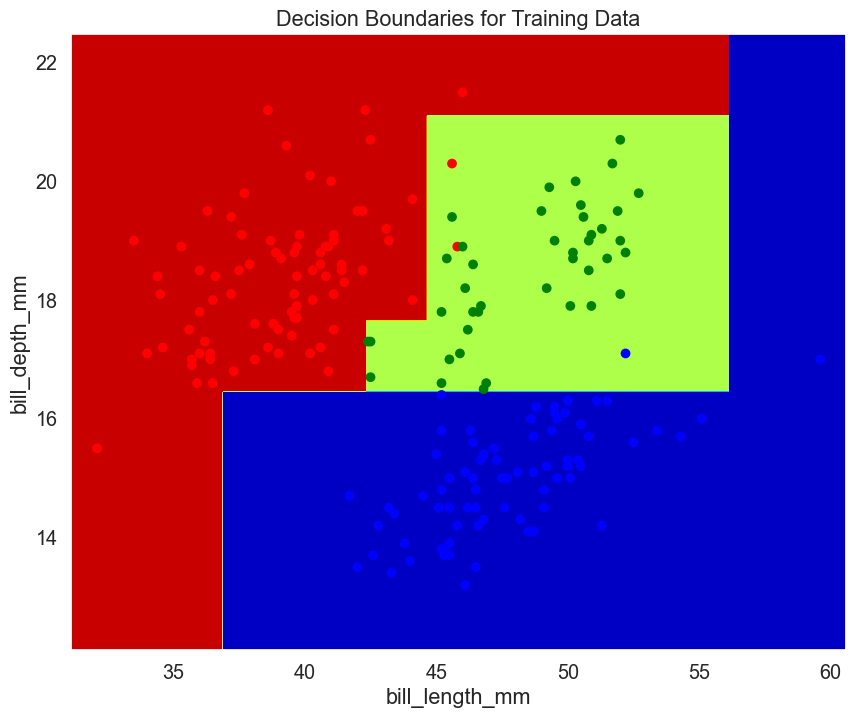

In [26]:
# Set a plot_step
plot_step = 0.02

plt.figure(figsize = (10, 8))

# Plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# plt.tight_layout(h_hap = 0.5, w_pad = 0.5, pad = 2.5)

Z = decision_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap = "jet_r") #blue and red coloring

plt.scatter(X_train[:, 0], X_train[:, 1], c = c_train)
plt.xlabel("bill_length_mm")
plt.ylabel("bill_depth_mm")
plt.title("Decision Boundaries for Training Data")

It seems that there are fewer points that are predicted incorrectly when the depth increases. Let's assess the performance of this decision tree algorithm with larger depth.

In [27]:
# predicted values on the testing data
test_pred_decision_tree = decision_tree.predict(X_test)

# The confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, test_pred_decision_tree)

# Convert confusion matrix into dataframe
matrix_df = pd.DataFrame(confusion_matrix)

In [28]:
# Output the confusion matrix
print(confusion_matrix)

[[63  1  1]
 [ 2 23  2]
 [ 0  6 36]]


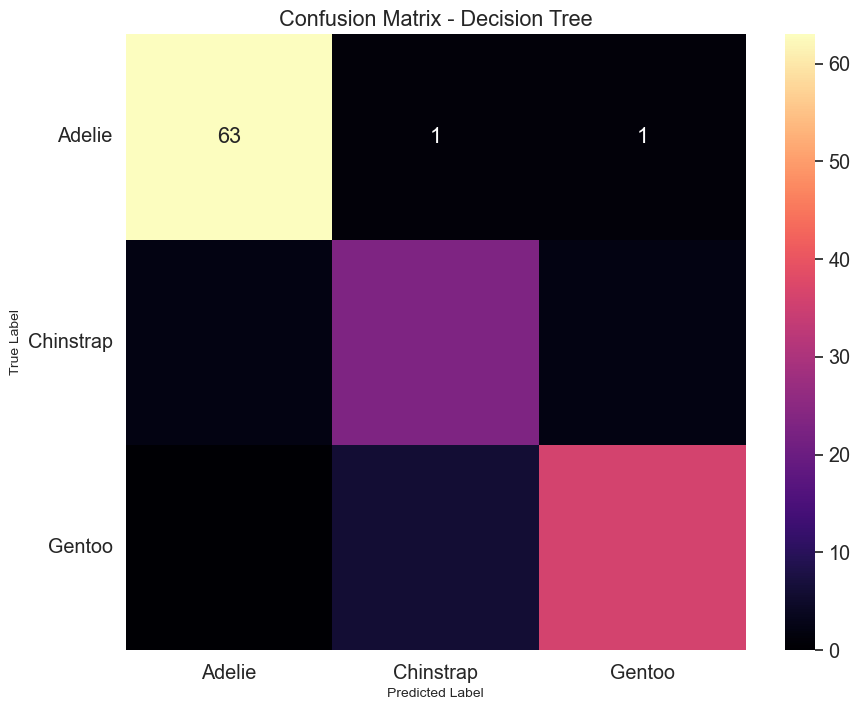

In [29]:
# Plot confusion matrix using seaborn
plt.figure(figsize = (10, 8))
ax = plt.axes()
sns.set(font_scale = 1.3)

sns.heatmap(matrix_df,
            annot = True,
            fmt = "g",
            ax = ax,
            cmap = "magma")

ax.set_title("Confusion Matrix - Decision Tree")
ax.set_xlabel("Predicted Label", fontsize = 10)
ax.set_xticklabels(labels)
ax.set_ylabel("True Label", fontsize = 10)
ax.set_yticklabels(labels, rotation = 0)
plt.show()

Next, to visualize the decision boundaries for testing data:

Text(0.5, 1.0, 'Decision Boundaries for Testing Data')

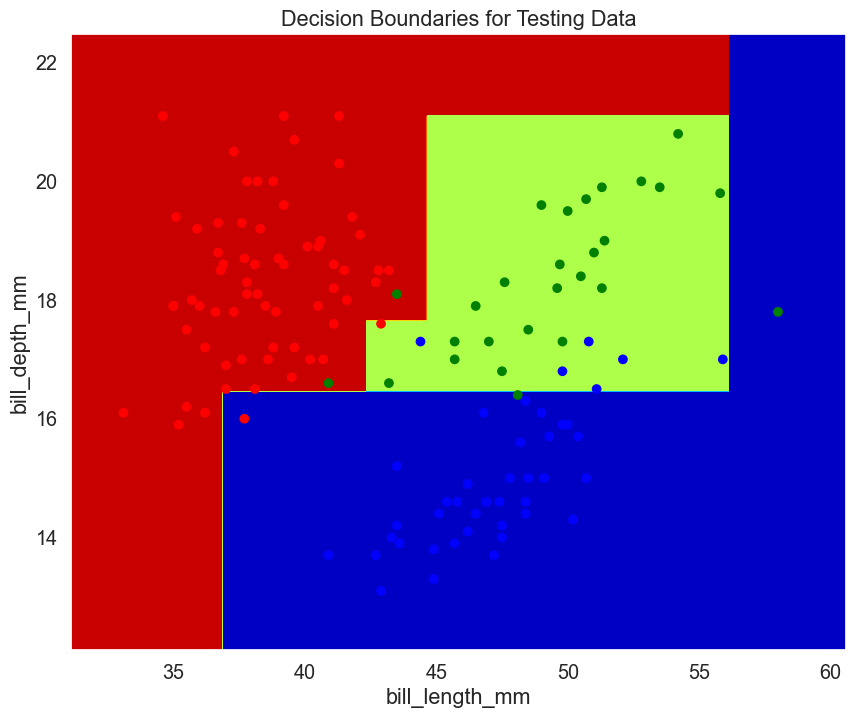

In [30]:
# Set a plot_step
plot_step = 0.02

plt.figure(figsize = (10, 8))

# Plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# plt.tight_layout(h_hap = 0.5, w_pad = 0.5, pad = 2.5)

Z = decision_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap = "jet_r") #blue and red coloring

plt.scatter(X_test[:, 0], X_test[:, 1], c = c_test)
plt.xlabel("bill_length_mm")
plt.ylabel("bill_depth_mm")
plt.title("Decision Boundaries for Testing Data")

Although there are also some points that are predicted incorrectly, the overall performance is good. Let's check some rates and scores that reflect the performance of the decision tree algorhthm!

In [31]:
print(f"accuracy score = {metrics.accuracy_score(y_test, test_pred_decision_tree)}")

accuracy score = 0.9104477611940298


The accuracy is close to the model with smaller depth.

In [31]:
print(f"precision score")

precision = metrics.precision_score(y_test,
                                    test_pred_decision_tree,
                                    average = None)

# Convert to pandas dataframe
precision_results = pd.DataFrame(precision, index = labels)

precision_results.rename(columns = {0:"precision"}, inplace = True)
precision_results

precision score


,precision
Adelie,0.969231
Chinstrap,0.766667
Gentoo,0.923077


Regarding precision, the accuracy of predicting Adelie penguins improves, whereas the precision for Chinstrap and Gentoo penguins declines when compared to a model with smaller depth.

In [32]:
# Recall and the f1-score
print(metrics.classification_report(y_test, test_pred_decision_tree))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        65
         1.0       0.77      0.85      0.81        27
         2.0       0.92      0.86      0.89        42

    accuracy                           0.91       134
   macro avg       0.89      0.89      0.89       134
weighted avg       0.91      0.91      0.91       134



The recall and the $F_1$ scores are almost the same as the previous model with smaller depth.

And thus, for this classification task, increasing the depth of the decision tree algorithm does not change the performance.

---

## Conclusion

The performance of the decision tree in classifying penguin species is satisfactory.

Increasing the depth of the decision tree algorithm does not affect performance for this specific classification task. However, for more complex problems, a greater depth in the decision tree might enhance performance.